In [8]:
from collections import defaultdict
import json
from pathlib import Path
import random as rn
from typing import List, Tuple, Union, Any, Dict


from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

# Metrics
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from keras import initializers, optimizers

# Splitting the datasets
from bella.data_types import TargetCollection, Target
# Models
from bella.models.tdlstm import LSTM, TDLSTM, TCLSTM
# Tokenisers
from bella.tokenisers import ark_twokenize
# Word Vectors
from bella.word_vectors import SSWE, GloveTwitterVectors
# Get the data
from bella.helper import read_config
# Parse the data
from bella.parsers import dong

In [9]:
# Useful functions
def train_val_split(train: 'bella.data_types.TargetCollection', 
                    split_size: float = 0.2, seed: Union[None, int] = 42
                   ) -> Tuple[Tuple[np.ndarray, np.ndarray],
                              Tuple[np.ndarray, np.ndarray]]:
    '''
    Splits the training dataset into a train and validation set in a
    stratified split.
    
    :param train: The training dataset that needs to be split into
    :param split_size: Fraction of the dataset to assign to the 
                       validation set.
    :param seed: Seed value to give to the stratified splitter. If 
                 None then it uses the radnom state of numpy.
    :return: Two tuples of length two where each tuple is the train 
             and validation splits respectively, and each tuple contains 
             the data (X) and class labels (y) respectively. Returns 
             ((X_train, y_train), (X_val, y_val))
    '''
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=split_size, random_state=seed)
    data = np.asarray(train.data_dict())
    sentiment = np.asarray(train.sentiment_data())
    for train_indexs, test_indexs in splitter.split(data, sentiment):
        train_data = data[train_indexs]
        test_data = data[test_indexs]

    convert_to_targets = lambda data: [Target(**target) for target in data]
    train = TargetCollection(convert_to_targets(train_data))
    val = TargetCollection(convert_to_targets(test_data))

    X_train = np.array(train.data_dict())
    y_train = np.array(train.sentiment_data())
    X_val = np.array(val.data_dict())
    y_val = np.array(val.sentiment_data())
    return (X_train, y_train), (X_val, y_val)

def evaluate_model(model_class: 'bella.models.KerasModel', 
                   model_kwargs: Dict[str, Any], 
                   word_vectors: 'bella.word_vectors.WordVectors', 
                   result_folder: Path, random_values: List[int]):
    '''
    Given a model class it will fit and predict for each different 
    random value and word vector. These predictions are then saved 
    in the model specific results folder that is created based on 
    name of the model within the result folder.
    
    :param model_class: The class of the model to evaluate e.g. LSTM
    :param model_kwargs: The keyword arguments to give to the model 
                         class construction e.g. `optimiser`
    :param word_vectors: The word vectors to evaluate over.
    :param result_folder: The folder to save the results to
    :param random_values: The random values to evaluate each word 
                          vector over.
    :return: Nothing but saves the results as a json file for each 
             word vector. Where the json file contains a List of 
             tuples where each tuple is (random_value, predictions)
    '''
    for word_vector in word_vectors:
        model = model_class(ark_twokenize, word_vector, **model_kwargs)
        model_result_folder = result_folder.joinpath(f'{str(model)}')
        model_result_folder.mkdir(parents=True, exist_ok=True)
        
        word_vector_fp = model_result_folder.joinpath(f'{str(model)} {str(word_vector)} '
                                                      'Repeated Results.json')
        # Do not re-write over exisiting data
        if word_vector_fp.is_file():
            print('File already exists, therefore assuming the data exists '
                  f'for file path {word_vector_fp}')
            continue
        param_predictions = model.evaluate_parameters(model, (X_train, y_train), (X_val, y_val), 
                                                X_test, 'reproducible', random_values, n_cpus)
        # Change the class labels back to original labels
        temp_param_predictions = []
        for random_value, predictions in param_predictions:
            predictions = [sent_vals_inv[prediction] for prediction in predictions]
            temp_param_predictions.append((random_value, predictions))

        with word_vector_fp.open('w') as word_vector_file:
            json.dump(temp_param_predictions, word_vector_file)

In [10]:
##
#  ADD YOUR CONFIG FILE PATH HERE 
##
CONFIG_FP = Path('..', 'config.yaml')

#
# Data set up
#

results_folder = Path(read_config('results_folder', CONFIG_FP))
results_folder = results_folder.joinpath('TDLstm')

# Load the datasets
dong_train = dong(read_config('dong_twit_train_data', CONFIG_FP))
dong_test = dong(read_config('dong_twit_test_data', CONFIG_FP))

(X_train, y_train), (X_val, y_val) = train_val_split(dong_train)
# The models do not accepts class labels that are less than 0
sent_vals = {-1: 0, 0: 1, 1: 2}
sent_vals_inv = {0: -1, 1: 0, 2: 1}
y_val = np.array([sent_vals[val] for val in y_val])
y_train = np.array([sent_vals[val] for val in y_train])

X_test = dong_test.data_dict()

In [12]:
#
# WORD VECTORS
#
# Get all the words from the train and test data so that we 
# can filter words from the Word Vectors so that all the 
# word vectors can be loaded into reasonable amount of memory
train_words = dong_train.word_list(ark_twokenize)
test_words = dong_test.word_list(ark_twokenize)
all_words = list(set(train_words + test_words))
# Load the word vectors
sswe = SSWE(filter_words=all_words)
glove_50 = GloveTwitterVectors(50, filter_words=all_words)
glove_100 = GloveTwitterVectors(100, filter_words=all_words)
glove_200 = GloveTwitterVectors(200, filter_words=all_words)
word_vectors = [sswe, glove_50, glove_100, glove_200]
n_cpus = 1

Loading glove twitter 50d from file
Loading glove twitter 100d from file
Loading glove twitter 200d from file


In [6]:
#
# All the model keyword arguments to match the original paper
#
uniform_init = initializers.RandomUniform(minval=-0.003, maxval=0.003)
lstm_layer_kwargs = {'kernel_initializer' : uniform_init,
                     'recurrent_initializer' : uniform_init,
                     'bias_initializer' : uniform_init}
dense_layer_kwargs = {'kernel_initializer' : uniform_init,
                      'bias_initializer' : uniform_init}
embedding_layer_kwargs = {'embeddings_initializer' : uniform_init}
model_kwargs = {'lstm_layer_kwargs': lstm_layer_kwargs,
                'dense_layer_kwargs': dense_layer_kwargs,
                'embedding_layer_kwargs': embedding_layer_kwargs,
                'optimiser': optimizers.SGD,
                'optimiser_params': {'lr': 0.01}}


# How does the random seed affect the LSTM based models

It is known that chagning the random seed value in neural sequence labelling cause the results to statistically significantly change [Reimers and Gurevych](https://aclanthology.info/papers/D17-1035/d17-1035). Therefore in this notebook we show the affect of changing the random seed value with respect to training the 3 LSTM based models that [Tang et al.](https://www.aclweb.org/anthology/C16-1311) presented in his paper. We then show if we can replicate their results. The models that they created are the following:

1. **LSTM** - Standard single layered LSTM where the hidden layer output is equal to the size of the input vector dimensions e.g. if the words vectors are 50 dimensions in size then the LSTM hidden state and output is 50 dimensions.
2. **TDLSTM** - Target Dependent LSTM. This consists of 2 LSTMs either side of the target word that the sentiment is with respect to. The Left LSTM reads words in from left to right and goes up to the last word in the target word. The right LSTM reads words right to left and goes up to the last word in the target word as well. Again the LSTM hidden state and output is the same as the dimension of the input.
3. **TCLSTM** - Target Context LSTM is the same as the TDLSTM but the input instead of being just the word vectors it reads in and word vectors are concatenated with the vector representation of the target word. If the target word is multiple words then it is the average of those word vectors.

The names of these models are direct matches to the class names that represent these models in our code base.

In [Tang et al.](https://www.aclweb.org/anthology/C16-1311) paper they never state the number of Epochs that they train for and instead of guessing the number we decided to use Early Stopping to find the optimal number of Epochs to train for.

However using Early Stopping comes with other drawbacks. As the dataset that they used for this paper (and all of the other datasets we look at) does not contain a validation set we have to create a train and validation set from the original training data. This creation of the validation set could cause some differences in ours and their results.

## Dataset used

The dataset we use is the same as [Tang et al.](https://www.aclweb.org/anthology/C16-1311) used in their paper which is [Dong et al](https://aclanthology.coli.uni-saarland.de/papers/P14-2009/p14-2009) Twitter dataset which is a general domain dataset.

## Word vectors used

We use the same word vectors as those shown in the paper apart from the SSWE-h and SSWE-r which we could not find, the *SSWE-u* is the equivalent to *SSWE* in our code base. We got the *SSWE* word vectors from the following [code base](https://github.com/bluemonk482/tdparse) and the Gove Twitter vectors from [here](https://nlp.stanford.edu/projects/glove/). However in our code base the word vectors will download automatically and then be saved within your user directory under the directory `.Bella`

## The experiment

Below we run each of the 3 models 30 times with different random seeds and then repeat this for each word vector. This can take a long time but can be speed up signifcantly if you use more than one CPU. The number of cpus to use can be changed by changing the `n_cpus` variable above, default is `1`. 

**The results from these experiments have been saved and therefore do not need to be repeated.** They have been saved under:

`../results/{model_name}/{model_name} {word_vector_name} Repeated Results.json`

where the variables could be: model_name = 'LSTM' and word_vector_name = 'SSWE' e.g. 

`../results/LSTM/LSTM SSWE Repeated Results.json`


### LSTM Evaluation

In [7]:
rn.seed(42)
random_values = [int(rn.uniform(0, 1000)) for i in range(30)] 
evaluate_model(LSTM, model_kwargs, word_vectors, results_folder, random_values)

#### TDLSTM Evaluation

In [ ]:
rn.seed(42)
random_values = [int(rn.uniform(0, 1000)) for i in range(30)] 
evaluate_model(TDLSTM, model_kwargs, word_vectors, results_folder, random_values)

#### TCLSTM Evaluation

In [ ]:
rn.seed(42)
random_values = [int(rn.uniform(0, 1000)) for i in range(30)] 
evaluate_model(TCLSTM, model_kwargs, word_vectors, results_folder, random_values)

## Analysis of the evaluations

Now we have all of the data saved in the respective result files we shall analysis it to see how much the results vary and how close we get to the result stated in Tang et al. paper.

A note on how the data is stored. We have the raw predictions for each model, for each of the 4 word vectors, and for each random seed in the 30 random seeds drawn from a uniform distribution. Therefore we have in total 3 \* 4 \* 30 raw predictions for the test data.

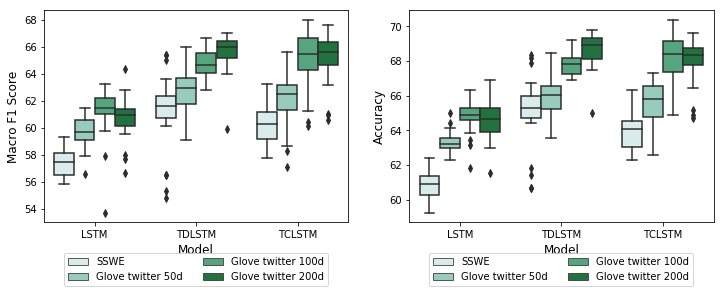

In [20]:
models = [LSTM, TDLSTM, TCLSTM]
model_data = defaultdict(list)
y_test = dong_test.sentiment_data()
for model in models:
    model_name = model.__name__
    model_result_folder = results_folder.joinpath(model_name)
    for word_vector in word_vectors:
        word_vector_name = str(word_vector).capitalize()
        if word_vector_name == 'Sswe':
            word_vector_name = 'SSWE'
        result_fp = model_result_folder.joinpath(f'{model_name} {str(word_vector)} '
                                                 'Repeated Results.json')
        with result_fp.open('r') as result_file:
            random_predictions = json.load(result_file)
        
        accuracies = []
        f1_scores = []
        for random_value, predictions in random_predictions:
            accuracies.append(accuracy_score(y_test, predictions) * 100)
            f1_scores.append(f1_score(y_test, predictions, average='macro') * 100)
        num_scores = len(accuracies)
        model_data['Model'].extend([model_name] * num_scores)
        model_data['Word Vector'].extend([word_vector_name] * num_scores)
        model_data['Macro F1 Score'].extend(f1_scores)
        model_data['Accuracy'].extend(accuracies)
model_data = pd.DataFrame(model_data)
fig, axs = plt.subplots(ncols=2)
axs[0] = sns.boxplot(x="Model", y="Macro F1 Score", hue="Word Vector", 
                 data=model_data, palette='BuGn', ax=axs[0])
axs[1] = sns.boxplot(x="Model", y="Accuracy", hue="Word Vector", 
                 data=model_data, palette='BuGn', ax=axs[1])
for ax in axs:
    ax.figure.set_size_inches(12,3.9)
    leg = ax.legend(loc=9, bbox_to_anchor=(0.5, -0.12), ncol=2)
axs[0].figure.savefig('TDLSTM dist results.png', bbox_extra_artists=(leg,), bbox_inches='tight', dpi=150)

As we can see above using different seed values affects the results quite a lot, more so for smaller embedding sizes when using the macro F1 score. These results come to the same conclusion as the original paper for both the ranking of the embeddings and the models.

### Overall results

Below we show the mean and maximum values of the repeated experiments above and state these as our reported results and compared them to the original results from Tang et al paper. As can be seen the maximum results are very close to the original, and the maximum results show the same ranking of the models when using the Macro F1 score.

In [69]:
mean_glove_200_results = {('Macro F1', 'LSTM'): [64.7], ('Macro F1', 'TDLSTM'): [69.0], 
                          ('Macro F1', 'TCLSTM'): [69.5], ('Accuracy', 'LSTM'): [66.5], 
                          ('Accuracy', 'TDLSTM'): [70.8], ('Accuracy', 'TCLSTM'): [71.5]}
glove_vectors = model_data['Word Vector'] == 'Glove twitter 200d'
for model in models:
    model_name = model.__name__
    model_specific_data = model_data['Model'] == model_name
    model_vec_query = model_specific_data & glove_vectors
    refined_data = model_data[model_vec_query]
    f1_data = refined_data['Macro F1 Score']
    acc_data = refined_data['Accuracy']
    mean_glove_200_results[('Macro F1', f'{model_name}')].append(f1_data.mean())
    mean_glove_200_results[('Macro F1', f'{model_name}')].append(f1_data.max())
    mean_glove_200_results[('Accuracy', f'{model_name}')].append(acc_data.mean())
    mean_glove_200_results[('Accuracy', f'{model_name}')].append(acc_data.max())
columns = pd.MultiIndex.from_tuples(list(mean_glove_200_results.keys()), names=['Metric', 'Model'])
pd.DataFrame(mean_glove_200_results, 
             index=['Original', 'Reproduced Mean', 'Reproduced Max'],
             columns=columns
            ).astype(float).round(2)

Metric          Macro F1               Accuracy              
Model               LSTM TDLSTM TCLSTM     LSTM TDLSTM TCLSTM
Original           64.70  69.00  69.50    66.50   70.8  71.50
Reproduced Mean    60.69  65.63  65.23    64.60   68.7  67.98
Reproduced Max     64.34  67.04  67.66    66.91   69.8  69.65

## Error Analysis

Here we are going to look at the number of Out Of Vocabularly (OOV) words the different word vectors have for the sentence text and target text for each sample in the Dong Twitter dataset. Just as a reminder that the LSTM only takes into account the sentence text and not the target text of which the sentiment is with respect to.

For the Glove Twitter vectors as they were trained on the same text we look at them as a group rather than indivdually as each one would have the same result. Therefore below we are only going to compare Glove Twitter to SSWE vectors.

Below are some handy functions to calculate the OOV stats

In [74]:
def avg_target_oov(target_data, word_list, tokenizer=ark_twokenize, whole_target=False):
    all_oov_count = []
    target_words_list = [ark_twokenize(data['target'].lower()) for data in target_data.data()]
    for target_words in target_words_list:
        count = 0
        oov_count = 0
        for word in target_words:
            if word not in word_list:
                oov_count += 1
            count += 1
        average_oov = oov_count / count
        if whole_target:
            all_oov_count.append(math.ceil(average_oov))
        else:
            all_oov_count.append(average_oov)
    return sum(all_oov_count) / len(all_oov_count)

def average_oov(target_data, word_list, tokenizer=ark_twokenize, whole_text=False):
    all_oov_count = []
    words_list = [ark_twokenize(data['text'].lower()) for data in target_data.data()]
    for words in words_list:
        count = 0
        oov_count = 0
        for word in words:
            if word not in word_list:
                oov_count += 1
            count += 1
        average_oov = oov_count / count
        if whole_text:
            all_oov_count.append(math.ceil(average_oov))
        else:
            all_oov_count.append(average_oov)
    return sum(all_oov_count) / len(all_oov_count)


In [75]:
name_word_list = [('SSWE', sswe._word_list), ('Glove', glove_200._word_list)]
train_results = pd.DataFrame(columns=['Average Target OOV', 'Target OOV', 
                                      'Average Text OOV', 'Text OOV'],
                             index=['SSWE', 'Glove'])
for name, word_list in name_word_list:
    train_results['Average Target OOV'][name] = avg_target_oov(dong_train, word_list)
    train_results['Target OOV'][name] = avg_target_oov(dong_train, word_list, whole_target=True)
    train_results['Average Text OOV'][name] = average_oov(dong_train, word_list)
    train_results['Text OOV'][name] = average_oov(dong_train, word_list, whole_text=True)

In [78]:
rounded_train_results = (train_results * 100).astype(float).round(2)
rounded_train_results

,Average Target OOV,Target OOV,Average Text OOV,Text OOV
SSWE,1.15,2.06,4.24,47.81
Glove,1.49,2.88,9.22,78.89


In [79]:
name_word_list = [('SSWE', sswe._word_list), ('Glove', glove_200._word_list)]
test_results = pd.DataFrame(columns=['Average Target OOV', 'Target OOV', 
                                     'Average Text OOV', 'Text OOV'],
                            index=['SSWE', 'Glove'])
for name, word_list in name_word_list:
    test_results['Average Target OOV'][name] = avg_target_oov(dong_test, word_list)
    test_results['Target OOV'][name] = avg_target_oov(dong_test, word_list, whole_target=True)
    test_results['Average Text OOV'][name] = average_oov(dong_test, word_list)
    test_results['Text OOV'][name] = average_oov(dong_test, word_list, whole_text=True)

In [81]:
rounded_test_results = (test_results * 100).astype(float).round(2)
rounded_test_results

,Average Target OOV,Target OOV,Average Text OOV,Text OOV
SSWE,1.13,2.02,4.25,46.97
Glove,2.02,3.76,9.02,78.76


As we can see above the number of OOV words in the SSWE is far fewer than the Glove vectors, espically for the number of texts that have no OOV words at all. However from what we can see from the result it would appear that the TCLSTM and TDLSTM require as few OOV words in the Target text as possible to make them work better than a sentence level classifier.